In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.datasets import mnist

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## Filtering out the Zerps for Faster Training

In [ ]:
only_zeros = X_train[y_train==0]

In [ ]:
only_zeros.shape

(5923, 28, 28)

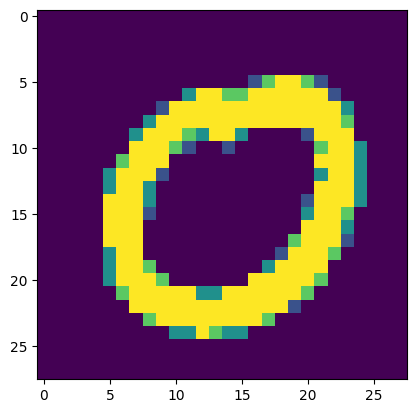

In [ ]:
plt.imshow(only_zeros[950])

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Flatten
from tensorflow.keras.models import Sequential

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 100

In [ ]:
generator = Sequential()
generator.add(Dense(100, activation="relu", input_shape=[codings_size]))
generator.add(Dense(150,activation='relu'))
generator.add(Dense(784, activation="sigmoid")) # 28*28 = 784
generator.add(Reshape([28,28]))

In [ ]:
discriminator = Sequential()
discriminator.add(Flatten(input_shape=[28,28]))
discriminator.add(Dense(150,activation='relu'))
discriminator.add(Dense(100,activation='relu'))
discriminator.add(Dense(1,activation="sigmoid"))

discriminator.compile(loss="binary_crossentropy", optimizer="adam")

In [ ]:
GAN = Sequential([generator, discriminator])

In [ ]:
discriminator.trainable = False # discreminator itself is only saying what is real or fake discreminator should not be trained in the second phase

In [ ]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [ ]:
GAN.layers

In [ ]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28)            143634    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 132951    
                                                                 
Total params: 276585 (1.06 MB)
Trainable params: 143634 (561.07 KB)
Non-trainable params: 132951 (519.34 KB)
_________________________________________________________________


In [ ]:
GAN.layers[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 150)               15150     
                                                                 
 dense_2 (Dense)             (None, 784)               118384    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 143634 (561.07 KB)
Trainable params: 143634 (561.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
GAN.layers[1].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 150)               117750    
                                                                 
 dense_4 (Dense)             (None, 100)               15100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 132951 (519.34 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 132951 (519.34 KB)
_________________________________________________________________


# Training Batches

In [ ]:
import tensorflow as tf

In [ ]:
batch_size = 32

In [ ]:
# my_data = X_train
my_data = only_zeros

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [ ]:
type(dataset)

tensorflow.python.data.ops.shuffle_op._ShuffleDataset

In [ ]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
epochs = 1



# Training Loop

In [ ]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################

        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])

        # Generate numbers based just on noise input
        gen_images = generator(noise)

        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)

        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

        # This gets rid of a Keras warning
        discriminator.trainable = True

        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)


        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################

        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])

        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)

        # Avois a warning
        discriminator.trainable = False

        GAN.train_on_batch(noise, y2)

print("TRAINING COMPLETE")

Currently on Epoch 1
	Currently on batch number 100 of 185
TRAINING COMPLETE


In [ ]:
noise = tf.random.normal(shape=[10, codings_size])

In [ ]:
noise.shape

TensorShape([10, 100])

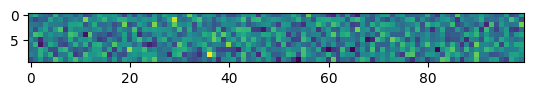

In [ ]:
plt.imshow(noise)

In [ ]:
image = generator(noise)

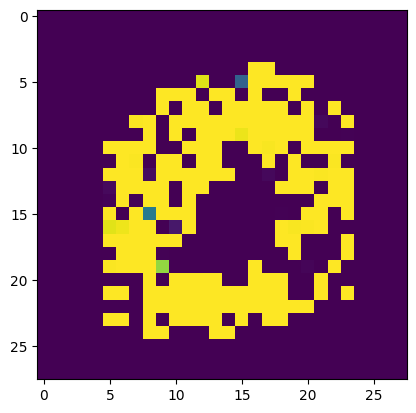

In [34]:
plt.imshow(image[0])